In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_daily.csv')

In [3]:
data.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [4]:
data.tail()

,# Date,Receipt_Count
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644
364,2021-12-31,10211187


In [5]:
data.isna().sum()

# Date           0
Receipt_Count    0
dtype: int64

In [6]:

df = pd.DataFrame(data=data)

In [7]:
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [8]:
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)
df.rename(columns = {'# Date':'Date', 'Receipt_Count' : 'Receipt'}, inplace = True)
df

Shape of the data=  (365, 2)
Column datatypes= 
 # Date           object
Receipt_Count     int64
dtype: object


,Date,Receipt
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289
...,...,...
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644


In [9]:
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index(df.Date)
df.drop('Date', axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 Receipt    int64
dtype: object


,Receipt
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289
...,...
2021-12-27,10350408
2021-12-28,10219445
2021-12-29,10313337


Text(0.5, 1.0, 'Trend of the Time Series')

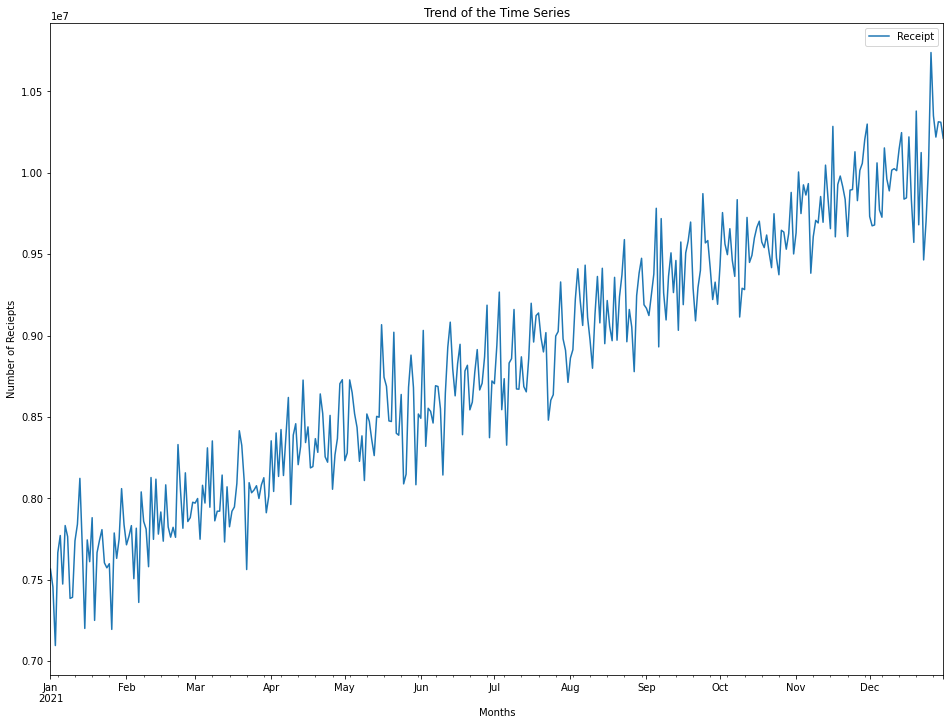

In [10]:
df.plot(figsize = (16,12))
plt.plot(df)
plt.xlabel('Months')
plt.ylabel('Number of Reciepts')
plt.title('Trend of the Time Series')

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

close_price = np.array(df).reshape(-1,1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape





(365, 1)

In [12]:
np.isnan(scaled_close).any()


False

In [13]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

In [15]:
print(df)

             Receipt
Date                
2021-01-01   7564766
2021-01-02   7455524
2021-01-03   7095414
2021-01-04   7666163
2021-01-05   7771289
...              ...
2021-12-27  10350408
2021-12-28  10219445
2021-12-29  10313337
2021-12-30  10310644
2021-12-31  10211187

[365 rows x 1 columns]


In [16]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [17]:
X_train.shape


(251, 99, 1)

In [18]:

X_test.shape

(14, 99, 1)

In [19]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1


import tensorflow as tf
from tensorflow import keras
model=tf.keras.Sequential([
    tf.keras.layers.LSTM(128,input_shape=(WINDOW_SIZE, X_train.shape[-1]),return_sequences=True),
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(64,return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='linear')
]
)

In [20]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [21]:
BATCH_SIZE = 5

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
45/45 [==============================] - 14s 192ms/step - loss: 0.0144 - val_loss: 0.0057
Epoch 2/50
45/45 [==============================] - 7s 166ms/step - loss: 0.0147 - val_loss: 0.0050
Epoch 3/50
45/45 [==============================] - 10s 216ms/step - loss: 0.0119 - val_loss: 0.0027
Epoch 4/50
45/45 [==============================] - 7s 154ms/step - loss: 0.0124 - val_loss: 0.0082
Epoch 5/50
45/45 [==============================] - 8s 174ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 6/50
45/45 [==============================] - 8s 167ms/step - loss: 0.0136 - val_loss: 0.0030
Epoch 7/50
45/45 [==============================] - 7s 161ms/step - loss: 0.0141 - val_loss: 0.0073
Epoch 8/50
45/45 [==============================] - 8s 174ms/step - loss: 0.0198 - val_loss: 0.0034
Epoch 9/50
45/45 [==============================] - 7s 153ms/step - loss: 0.0189 - val_loss: 0.0052
Epoch 10/50
45/45 [==============================] - 8s 175ms/step - loss: 0.0205 - val_loss: 0.01

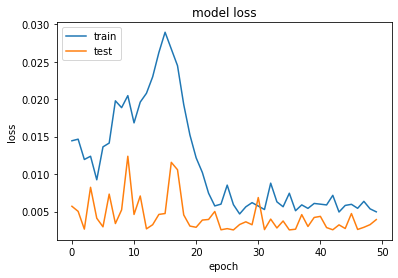

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()